# For Debug `jax-cfd` Fluid Solver

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import seaborn as sns
import xarray
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
from tqdm import tqdm

import sys
sys.path.insert(1, '/home/alam/Desktop/Code/jax-cfd/jax_cfd/')
import jax_cfd.sb as cfd
import utils

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
size = 64
density = 1.
viscosity = 4e-3

angular_velocity = 1.0
shear_rate = 3/2 * angular_velocity

aspect_ratio = 1.5 #2.0

total_time = 2 * jnp.pi * 10 / (shear_rate * 2 * jnp.pi)
outer_steps = 1#200

max_velocity = shear_rate * 2 * jnp.pi
cfl_safety_factor = 0.0005

seed = 0

In [3]:
# Define the physical dimensions of the simulation.
domain = ((-jnp.pi, jnp.pi), (-jnp.pi, jnp.pi)) # ((0, 2*jnp.pi), (0, 2*jnp.pi)) #
grid = cfd.grids.Grid((size, size), domain=domain)

# Construct an initial velocity field with constant x velocity
x0 = 0 #0.5 * 2 * jnp.pi
y0 = 0 #0.5 * 2 * jnp.pi
sigma = 0.05 * 2 * jnp.pi

def smooth_mask(x, y, x0, y0, aspect_ratio, width=0.1):
    phi = ((x - x0)**2 / 1.0**2 + (y - y0)**2 / aspect_ratio**2) - 1.0
    return 0.5 * (1.0 - jnp.tanh(phi / width))


x_velocity_fn = lambda x, y: jnp.zeros_like(x) + shear_rate * 1/(aspect_ratio - 1) * 1/aspect_ratio * (y-y0) * smooth_mask(x, y, x0, y0, aspect_ratio, grid.step[0]*4)
y_velocity_fn = lambda x, y: - shear_rate * x - shear_rate * 1/(aspect_ratio - 1) * aspect_ratio * (x-x0) * smooth_mask(x, y, x0, y0, aspect_ratio, grid.step[0]*4) 
v0 = cfd.initial_conditions.initial_velocity_field((x_velocity_fn, y_velocity_fn), grid, 
        velocity_bc = (cfd.boundaries.shearingbox_boundary_conditions(grid.ndim, shear_rate, 0.0, 'vx'),
                        cfd.boundaries.shearingbox_boundary_conditions(grid.ndim, shear_rate, 0.0, 'vy')))

In [4]:
def central_diff(v, dx):
    """
    Compute the central difference of a 2 dimensional velocity field.
    """
    vx = v[...,0]
    vy = v[...,1]
    return (np.roll(vx, -1, axis=0) - np.roll(vx, 1, axis=0)) / (2 * dx), \
           (np.roll(vx, -1, axis=1) - np.roll(vx, 1, axis=1)) / (2 * dx), \
           (np.roll(vy, -1, axis=0) - np.roll(vy, 1, axis=0)) / (2 * dx), \
           (np.roll(vy, -1, axis=1) - np.roll(vy, 1, axis=1)) / (2 * dx)


def compute_vorticity(v, dx):
    """
    Compute the vorticity of a 2D velocity field.
    """

    dvx_dx, dvx_dy, dvy_dx, dvy_dy = central_diff(v, dx)
    return dvy_dx - dvx_dy

x = np.linspace(0, 2 * np.pi, size, endpoint=False) + grid.step[0]/2  
#u0y = np.tile(shear_rate * x, (size, 1)).transpose()

v0_data = np.stack([v0[0].data, v0[1].data], axis = -1)
w0 = compute_vorticity(v0_data, grid.step[0])

Text(0.5, 1.0, '$w_{0}$')

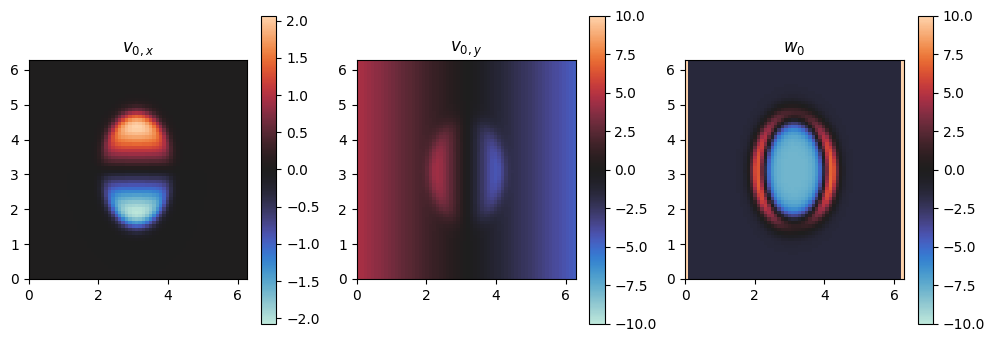

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
v0x_plot = ax[0].imshow(v0[0].data.transpose(), origin='lower', cmap=sns.cm.icefire, extent=(0,2*jnp.pi,0,2*jnp.pi))# vmin=-10, vmax=10, extent=(0,2*jnp.pi,0,2*jnp.pi))
v0y_plot = ax[1].imshow(v0[1].data.transpose(), origin='lower', cmap=sns.cm.icefire, vmin=-10, vmax=10, extent=(0,2*jnp.pi,0,2*jnp.pi))
w0_plot = ax[2].imshow(w0.transpose(), origin='lower', cmap=sns.cm.icefire, vmin=-10, vmax=10, extent=(0,2*jnp.pi,0,2*jnp.pi))
plt.colorbar(v0x_plot, ax=ax[0])
plt.colorbar(v0y_plot, ax=ax[1])
plt.colorbar(w0_plot, ax=ax[2])
ax[0].set_title(r"$v_{0,x}$")
ax[1].set_title(r"$v_{0,y}$")
ax[2].set_title(r"$w_{0}$")

In [6]:
# Choose a time step.
dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

inner_steps = 1 #total_time // (outer_steps*dt)

# Add in forcing
forcing = cfd.forcings.shearingbox_turbulence_forcing(grid, 
                                                 constant_magnitude=1.0,
                                                 constant_wavenumber=4.0,
                                                 linear_coefficient=-0.1,
                                                 angular_velocity=angular_velocity,
                                                 shear_rate=shear_rate,
                                                 dt=dt,
                                                 forced=False)

# In case for a change in viscosity term
diffuse = cfd.diffusion.diffuse

step_fn = jax.jit(cfd.equations.semi_implicit_navier_stokes_sb(
        density=density, viscosity=viscosity, dt=dt, grid=grid,
        diffuse=diffuse, forcing=forcing))

step_fn = cfd.funcutils.repeated_sb(step_fn,steps=inner_steps,dt=dt)
rollout_fn = jax.jit(cfd.funcutils.trajectory_sb(step_fn, outer_steps, Dt=dt*inner_steps))

In [7]:
_, v = jax.device_get(rollout_fn(v0))

In [8]:
vx = cfd.grids.GridVariable(cfd.grids.GridArray(v[0].data[0], v[0].offset, grid), bc = cfd.boundaries.shearingbox_boundary_conditions(2, shear_rate, inner_steps*dt, 'vx'))
vy = cfd.grids.GridVariable(cfd.grids.GridArray(v[1].data[0], v[1].offset, grid), bc = cfd.boundaries.shearingbox_boundary_conditions(2, shear_rate, inner_steps*dt, 'vy'))
v = tuple([vx, vy])

In [9]:
v_data = np.stack([v[0].data, v[1].data], axis = -1)
div_v = cfd.finite_differences.divergence(v)

Text(0.5, 1.0, '$\\nabla\\cdot \\mathbf{v}$')

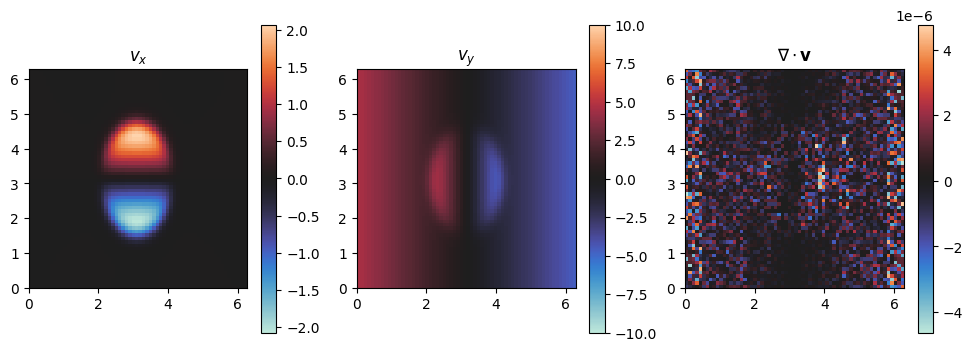

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
vx_plot = ax[0].imshow(v[0].data.transpose(), origin='lower', cmap=sns.cm.icefire, extent=(0,2*jnp.pi,0,2*jnp.pi))# vmin=-10, vmax=10, extent=(0,2*jnp.pi,0,2*jnp.pi))
vy_plot = ax[1].imshow(v[1].data.transpose(), origin='lower', cmap=sns.cm.icefire, vmin=-10, vmax=10, extent=(0,2*jnp.pi,0,2*jnp.pi))
divv_plot = ax[2].imshow(div_v.data.transpose(), origin='lower', cmap=sns.cm.icefire, extent=(0,2*jnp.pi,0,2*jnp.pi))
plt.colorbar(vx_plot, ax=ax[0])
plt.colorbar(vy_plot, ax=ax[1])
plt.colorbar(divv_plot, ax=ax[2])
ax[0].set_title(r"$v_{x}$")
ax[1].set_title(r"$v_{y}$")
ax[2].set_title(r"$\nabla\cdot \mathbf{v}$")